## Netflix Dataset EDA
### This notebook combines data cleaning, exploratory data analysis, and preparation steps for building a Netflix recommendation model. 
The workflow includes:
1. Loading and cleaning data: I fixed any missing information and removed unusual entries that might throw off my results.
2. Analyzing and visualizing the data: I looked at patterns in how users rate different types of movies and created charts to help see these relationships clearly.
3. Preparing the final datasets for recommendation model building: I created new helpful features from existing data and removed anything that wasn't useful for making good recommendation model.

In [3]:
# Import Libraries

# data processing libraries
import pandas as pd
import numpy as np
import polars as pl
from collections import deque
import time
import random
import os
from io import StringIO

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from joypy import joyplot

# NLP processing
import nltk

# API access (for genre prediction)
import anthropic
from dotenv import load_dotenv

In [4]:
# Load environment variables from .env file
load_dotenv()

# Download NLTK resources
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shruti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Part 1: Netflix Movie Metadata Cleaning and IMDb Integration
### 1.1 Clean Netflix Movie Titles Data

In [5]:
input_file = "../data/raw/movie_titles.csv"
fixed_lines = []

# Fix formatting issues in the original dataset (missing quotes around titles)
with open(input_file, "r", encoding="latin1") as infile:
    for line in infile:
        parts = line.strip().split(",", 2)  # Split only on the first two commas
        if len(parts) == 3:
            movie_id, release_year, title = parts
            title = f'"{title}"'  # Add quotes around the title
            fixed_lines.append(f"{movie_id},{release_year},{title}")
        else:
            fixed_lines.append(line.strip())  

csv_data = '\n'.join(fixed_lines)
column_names = ["movie_id", "release_year", "title"]
netflix_movies_df = pd.read_csv(StringIO(csv_data), names=column_names, header=None)
print(f"Netflix movies dataset shape: {netflix_movies_df.shape}")
netflix_movies_df.head()

Netflix movies dataset shape: (17770, 3)


,movie_id,release_year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


### 1.2 Load and Prepare IMDb Movie Details

In [ ]:
# Select relevant columns for recommendation system purposes
required_columns = [
    "genres", "budget", "original_title", "popularity",
    "production_companies", "production_countries",
    "title", "vote_average", "vote_count", "overview"
]

# Load IMDb movie details with selected columns
all_movies_df = pd.read_csv("../data/raw/AllMoviesDetailsCleaned.csv", sep=";", usecols=required_columns, low_memory=False)
print(f"IMDb movies dataset shape: {all_movies_df.shape}")
all_movies_df.head()

IMDb movies dataset shape: (329044, 10)


,budget,genres,original_title,overview,popularity,production_companies,production_countries,title,vote_average,vote_count
0,0,Drama|Crime,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,0.823904,Villealfa Filmproduction Oy,Finland,Ariel,7.1,40
1,0,Drama|Comedy,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",0.47445,Villealfa Filmproduction Oy,Finland,Shadows in Paradise,7.0,32
2,4000000,Crime|Comedy,Four Rooms,It's Ted the Bellhop's first night on the job....,1.698,Miramax Films,United States of America,Four Rooms,6.5,485
3,0,Action|Thriller|Crime,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",1.32287,Universal Pictures,Japan,Judgment Night,6.5,69
4,42000,Documentary,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,0.054716,inLoops,Austria,Life in Loops (A Megacities RMX),6.4,4


### 1.3 Merge Netflix and IMDb Datasets

In [6]:
# Merge both dataframes on 'title' to keep only common titles
merged_df = pd.merge(netflix_movies_df, all_movies_df, on="title", how="inner")

# Remove duplicate titles if any
merged_df = merged_df.drop_duplicates(subset=["title"])

# Display result
print(f"Merged dataset shape: {merged_df.shape}")
print(merged_df.dtypes)

Merged dataset shape: (10945, 12)
movie_id                  int64
release_year            float64
title                    object
budget                    int64
genres                   object
original_title           object
overview                 object
popularity               object
production_companies     object
production_countries     object
vote_average            float64
vote_count                int64
dtype: object


### 1.4 Handle Missing Values

In [ ]:
# Check for missing values in the merged dataset
missing_values = merged_df.isna().sum()
print("Missing values in each column:")
print(missing_values)

# Remove rows where 'release_year' or 'overview' have missing values
merged_df = merged_df.dropna(subset=["release_year", "overview"])
merged_df = merged_df.reset_index(drop=True)

# Recheck missing values
print("Missing values after cleaning:")
print(merged_df.isna().sum())

Missing values in each column:
movie_id                  0
release_year              2
title                     0
budget                    0
genres                  719
original_title            0
overview                 63
popularity                0
production_companies      0
production_countries      0
vote_average              0
vote_count                0
dtype: int64
Missing values after cleaning:
movie_id                  0
release_year              0
title                     0
budget                    0
genres                  699
original_title            0
overview                  0
popularity                0
production_companies      0
production_countries      0
vote_average              0
vote_count                0
dtype: int64


### 1.5 Handle Missing Genres

In [ ]:
# Extract unique genres from the dataset
unique_genres = set()
all_genres = merged_df['genres'].dropna().str.split('|').explode()
unique_genres.update(all_genres)
unique_genres = sorted(unique_genres)
print(f"Number of unique genres: {len(unique_genres)}")
print("Unique genres:", unique_genres)

# Get API-related parameters
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY")
CLAUDE_MODEL = os.getenv("CLAUDE_MODEL", "claude-3-5-sonnet-20241022")
INPUT_TOKEN_LIMIT = int(os.getenv("INPUT_TOKEN_LIMIT", 8000))  
OUTPUT_TOKEN_LIMIT = int(os.getenv("OUTPUT_TOKEN_LIMIT", 100))  
MAX_REQUESTS_PER_MINUTE = int(os.getenv("MAX_REQUESTS_PER_MINUTE", 50))
TIME_WINDOW = 60  # 60 seconds
client = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)
request_times = deque()
# Prepare genres string for LLM prompt
unique_genres_str = "|".join(unique_genres)

# Function to predict genres using LLM
def predict_genres_from_llm(overview):
    prompt = f"Given the following movie overview, assign the most appropriate genre(s) strictly from this predefined list: \
    {unique_genres_str}. Only return genres from this list. If no suitable match exists, return 'Unknown'. \
    Format the output as 'Genre1|Genre2|Genre3' with no extra words:\n\n{overview}"
    # Check if input tokens exceed the limit
    if len(prompt) > INPUT_TOKEN_LIMIT:
        raise ValueError(f"Prompt exceeds the input token limit of {INPUT_TOKEN_LIMIT} characters.")
    try:
        response = client.messages.create(
            model=CLAUDE_MODEL,
            max_tokens=OUTPUT_TOKEN_LIMIT,
            messages=[{"role": "user", "content": prompt}]
        )     
        predicted_genre = response.content[0].text.strip()
        return predicted_genre
    except Exception as e:
        print(f"Error: {e}")
        return None

# Function to enforce rate limit
def enforce_rate_limit():
    current_time = time.time()
    while request_times and request_times[0] < current_time - TIME_WINDOW:
        request_times.popleft()
    if len(request_times) >= MAX_REQUESTS_PER_MINUTE:
        wait_time = TIME_WINDOW - (current_time - request_times[0]) + random.uniform(0.1, 0.5)
        print(f"Rate limit reached. Sleeping for {wait_time:.2f} seconds.")
        time.sleep(wait_time)
    request_times.append(current_time)

# Function to process each overview sequentially
def process_genres_sequentially(missing_genre_rows):
    completed_count = 0
    modified_rows = []
    total_missing = len(missing_genre_rows)  
    for idx, row in missing_genre_rows.iterrows():
        overview = row['overview']
        enforce_rate_limit()  # Ensure we stay within API limits
        predicted_genre = predict_genres_from_llm(overview)  
        if predicted_genre is not None:
            completed_count += 1
            modified_rows.append((idx, predicted_genre))
            print(f"Row {idx}:")
            print(f"Overview: {overview[:100]}...") 
            print(f"Predicted Genre: {predicted_genre}")
            print("-" * 50)  
        print(f"Total Completed: {completed_count} out of {total_missing} missing genres.")
        print("=" * 50)
    return completed_count, modified_rows

# Select rows with missing genres
merged_df_copy = merged_df.copy()
missing_genre_rows = merged_df_copy[merged_df_copy['genres'].isna()]
total_missing = len(missing_genre_rows)
print(f"Total missing genres: {total_missing}")
completed_count, modified_rows = process_genres_sequentially(missing_genre_rows)
print(f"\nTotal Completed: {completed_count} out of {total_missing} missing genres.")

Number of unique genres: 20
Unique genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Total missing genres: 699
Row 2:
Overview: Paula Abdul has hit many high points in her show biz career -- Laker Girl, singing star and "America...
Predicted Genre: Music|Documentary
--------------------------------------------------
Total Completed: 1 out of 699 missing genres.
Row 11:
Overview: Drama - A NYC psychiatrist is diagnosed with leukemia - and when he finds out he was adopted, he tra...
Predicted Genre: Drama
--------------------------------------------------
Total Completed: 2 out of 699 missing genres.
Row 18:
Overview: Clayton has a problem with his roommate Brian... he's secretly in love with him! Blinded by passion,...
Predicted Genre: Romance|Comedy|Drama
--------------------------------------------------


In [8]:
# After filling in the missing genres, assign the predicted genres to the 'genres' column
for idx, predicted_genre in modified_rows:
    merged_df_copy.at[idx, 'genres'] = predicted_genre

# Check for remaining missing values
missing_values = merged_df_copy.isna().sum()
print("Missing values after genre prediction:")
print(missing_values)

Missing values after genre prediction:
movie_id                0
release_year            0
title                   0
budget                  0
genres                  0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
vote_average            0
vote_count              0
dtype: int64


### 1.6 Handle Problematic Genres

In [ ]:
# Clean the 'genres' column and identify problematic genres
problematic_keywords = [
    "experimental films", 
    "sports", 
    "sport", 
    "unknown"
]

# Clean the 'genres' column by stripping whitespaces and converting to lowercase
merged_df_copy['genres_clean'] = merged_df_copy['genres'].str.strip().str.lower()

# Filter out problematic genres
filtered_df = merged_df_copy[merged_df_copy['genres_clean'].str.contains('|'.join(problematic_keywords), case=False, na=False)]
print(f"Found {len(filtered_df)} rows with problematic genres")
merged_df_cleaned = merged_df_copy.drop(filtered_df.index)
print(f"Dataset shape after removing problematic genres: {merged_df_cleaned.shape}")

# Verify the genres again
unique_genres = set()
all_genres = merged_df_cleaned['genres'].dropna().str.split('|').explode()
unique_genres.update(all_genres)
unique_genres = sorted(unique_genres)
print(f"Number of unique genres after cleaning: {len(unique_genres)}")

Found 30 rows with problematic genres
Dataset shape after removing problematic genres: (10850, 13)
Number of unique genres after cleaning: 22


### 1.7 Final Cleanup and Save First Stage Dataset

In [ ]:
# Remove unnecessary columns
merged_df_cleaned = merged_df_cleaned.drop(columns=['original_title', 'genres_clean'])

# Save the cleaned dataset
merged_df_cleaned.to_csv("../data/cleaned/postEDA1_netflix_titles.csv", index=False)
print("Initial cleaned dataset saved to ../data/cleaned/postEDA1_netflix_titles.csv")

Initial cleaned dataset saved to ./data/cleaned/postEDA1_netflix_titles.csv


## Part 2: Feature Analysis and Visualizations

In [ ]:
# Load the Netflix movies dataset from previous step
netflix_movies_df = pd.read_csv(
    '../data/cleaned/postEDA1_netflix_titles.csv',
    header=0,
    dtype=str,
    delimiter=",",
    skipinitialspace=True,
    quotechar='"',
)

print(f"Dataset shape: {netflix_movies_df.shape}")
netflix_movies_df.head(3)

Dataset shape: (10850, 11)


,movie_id,release_year,title,budget,genres,overview,popularity,production_companies,production_countries,vote_average,vote_count
0,1,2003.0,Dinosaur Planet,0,Documentary|Animation,A four-episode animated series charting the ad...,0.055543,none,none,7.0,1
1,3,1997.0,Character,4500000,Drama|Foreign|History,J.W. Katadreuffe is the son of Joba Katadreuff...,0.258284,First Floor Features,Belgium,7.7,21
2,4,1994.0,Paula Abdul's Get Up & Dance,0,Music|Documentary,Paula Abdul has hit many high points in her sh...,0.00079,none,none,0.0,0


In [12]:
# Convert relevant columns to numeric types
numeric_columns = ['vote_average', 'vote_count', 'release_year', 'budget']
for col in numeric_columns:
    netflix_movies_df[col] = pd.to_numeric(netflix_movies_df[col], errors='coerce')

# Handle the popularity column's specific formatting issue (comma instead of period for decimal)
netflix_movies_df['popularity'] = netflix_movies_df['popularity'].replace({',': '.'}, regex=True)
netflix_movies_df['popularity'] = pd.to_numeric(netflix_movies_df['popularity'], errors='coerce')

# Display data types
print("Column data types after conversion:")
print(netflix_movies_df.dtypes)


Column data types after conversion:
movie_id                 object
release_year            float64
title                    object
budget                    int64
genres                   object
overview                 object
popularity              float64
production_companies     object
production_countries     object
vote_average            float64
vote_count                int64
dtype: object


In [13]:
# Define the numerical columns for analysis
num_cols = ["release_year", "vote_average", "vote_count", "popularity", "budget"]

# Check for zero/missing values in key numeric columns
total_rows = len(netflix_movies_df)
for col in num_cols:
    rows_with_zero_in_col = len(netflix_movies_df[netflix_movies_df[col] == 0])
    missing_pct = (rows_with_zero_in_col / total_rows) * 100
    nan_pct = (netflix_movies_df[col].isna().sum() / total_rows) * 100
    print(f"Column {col}: {missing_pct:.2f}% zeros, {nan_pct:.2f}% NaN values")

Column release_year: 0.00% zeros, 0.00% NaN values
Column vote_average: 9.91% zeros, 0.00% NaN values
Column vote_count: 9.77% zeros, 0.00% NaN values
Column popularity: 0.95% zeros, 0.00% NaN values
Column budget: 72.09% zeros, 0.00% NaN values


In [ ]:
# Remove columns with limited analytical value (budget has high % of zeros)
netflix_movies_df.drop(columns=['budget'], inplace=True)
num_cols.remove('budget') 
print(f"Removed 'budget' column, remaining numerical columns: {num_cols}")

Removed 'budget' column, remaining numerical columns: ['release_year', 'vote_average', 'vote_count', 'popularity']


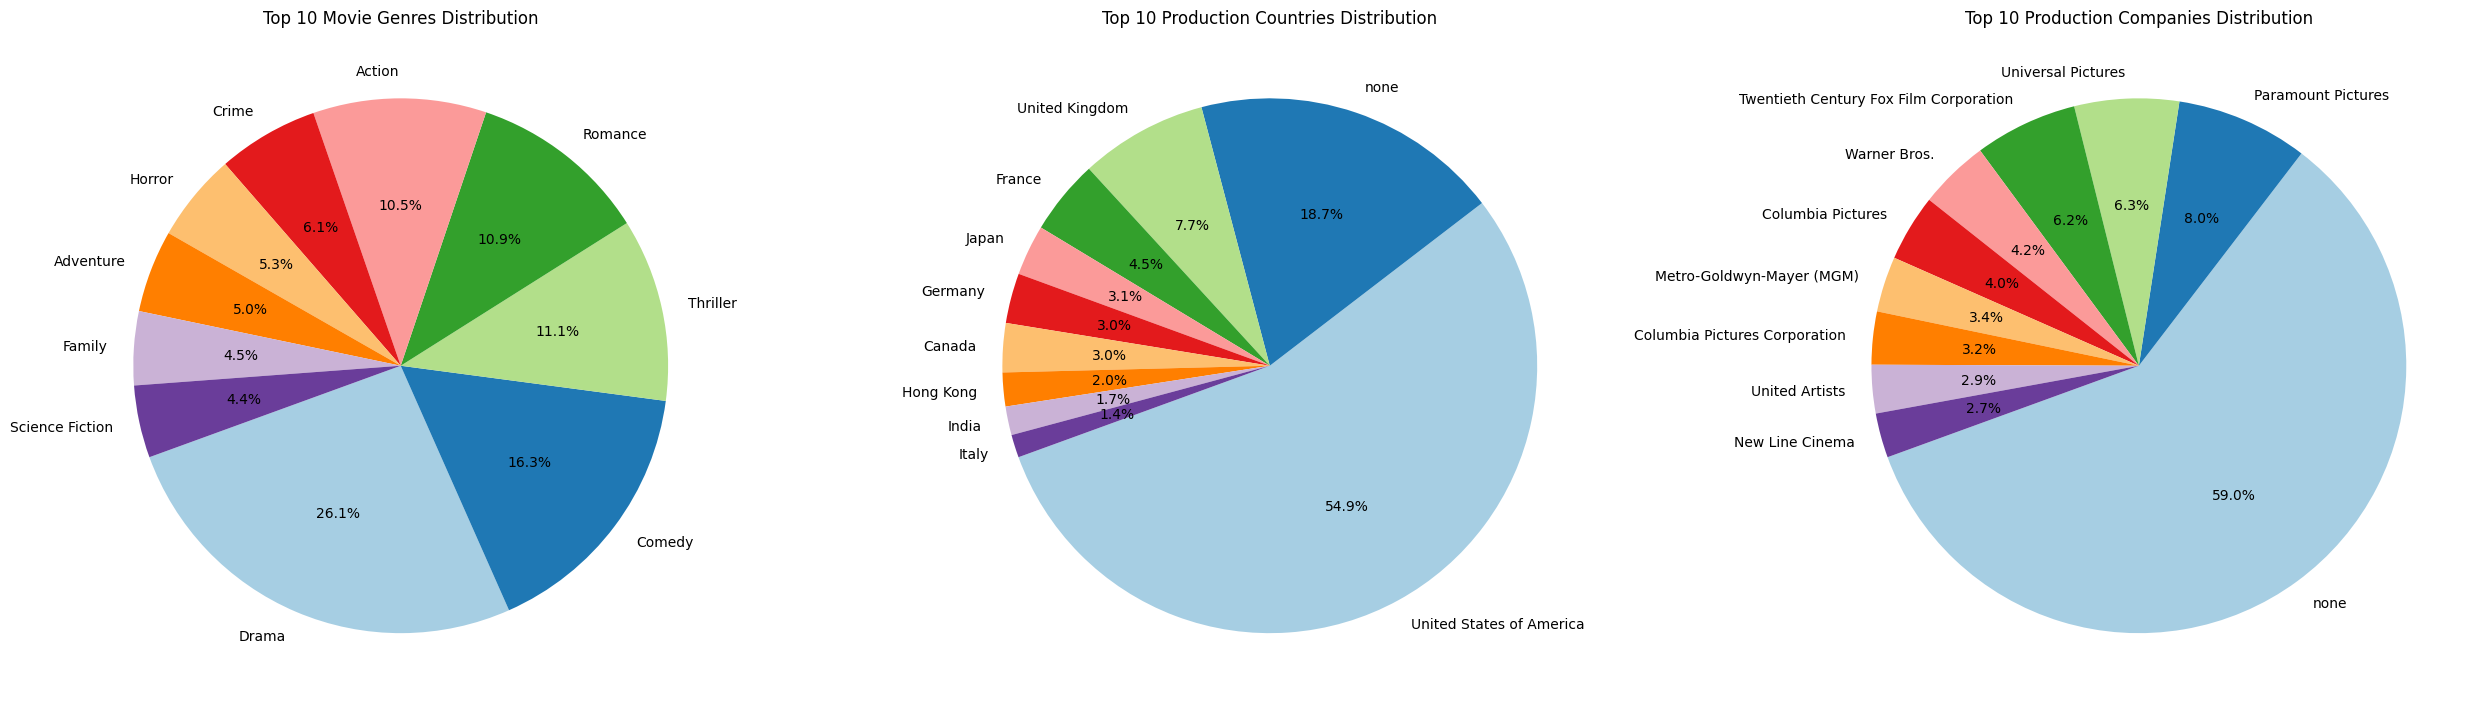

In [34]:
# Analyze genre distribution
all_genres = netflix_movies_df["genres"].dropna().str.split("|").explode()
top_genres = all_genres.value_counts().nlargest(10)

# Analyze country and company distributions
top_countries = netflix_movies_df["production_countries"].value_counts().nlargest(10)
top_companies = netflix_movies_df["production_companies"].value_counts().nlargest(10)

# Create a consolidated visualization for key categorical variables
fig, axes = plt.subplots(1, 3, figsize=(25, 10))

# Top Genres Pie Chart
axes[0].pie(top_genres, labels=top_genres.index, autopct='%1.1f%%', startangle=200, colors=plt.cm.Paired.colors)
axes[0].set_title("Top 10 Movie Genres Distribution")

# Production Countries Pie Chart
axes[1].pie(top_countries, labels=top_countries.index, autopct='%1.1f%%', startangle=200, colors=plt.cm.Paired.colors)
axes[1].set_title("Top 10 Production Countries Distribution")

# Production Companies Pie Chart
axes[2].pie(top_companies, labels=top_companies.index, autopct='%1.1f%%', startangle=200, colors=plt.cm.Paired.colors)
axes[2].set_title("Top 10 Production Companies Distribution")

plt.tight_layout()
plt.show()

Based on the pie charts above:
- **production_countries** has 54% of entries as 'USA' and 19% as 'None'
- **production_companies** has about 60% unknown values
These columns provide limited additional insights and can be removed.

In [35]:
# Drop columns with limited analytical value
netflix_movies_df = netflix_movies_df.drop(columns=["production_countries", "production_companies"])
print(f"Dataset shape after removing low-value columns: {netflix_movies_df.shape}")

Dataset shape after removing low-value columns: (10850, 8)


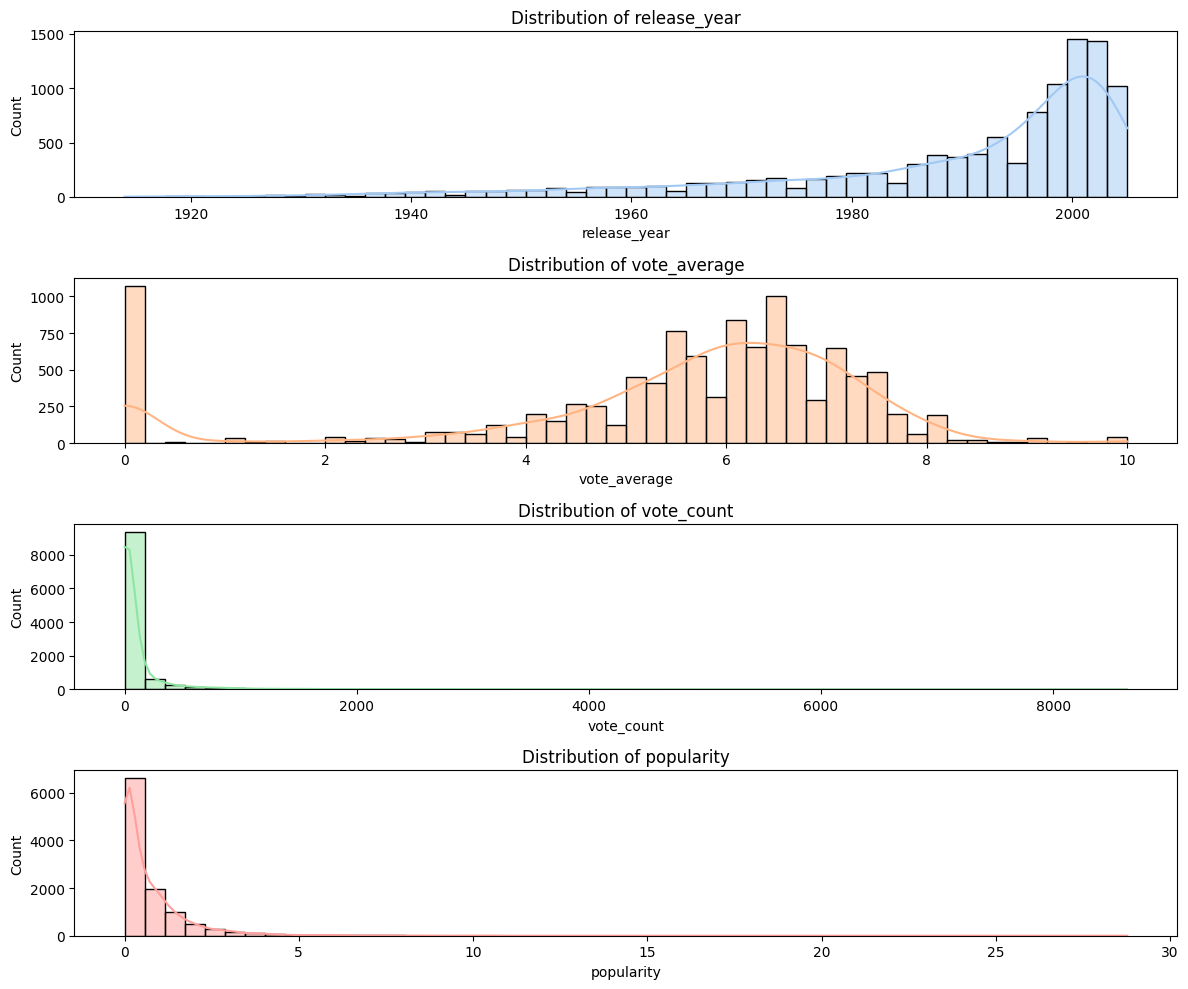

In [43]:
# Visualizing Numerical Distributions
plt.figure(figsize=(12, 10))
pastel_colors = sns.color_palette("pastel", len(num_cols))

# Loop through each numerical column and create a histogram with KDE
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.histplot(netflix_movies_df[col], bins=50, kde=True, color=pastel_colors[i-1])
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

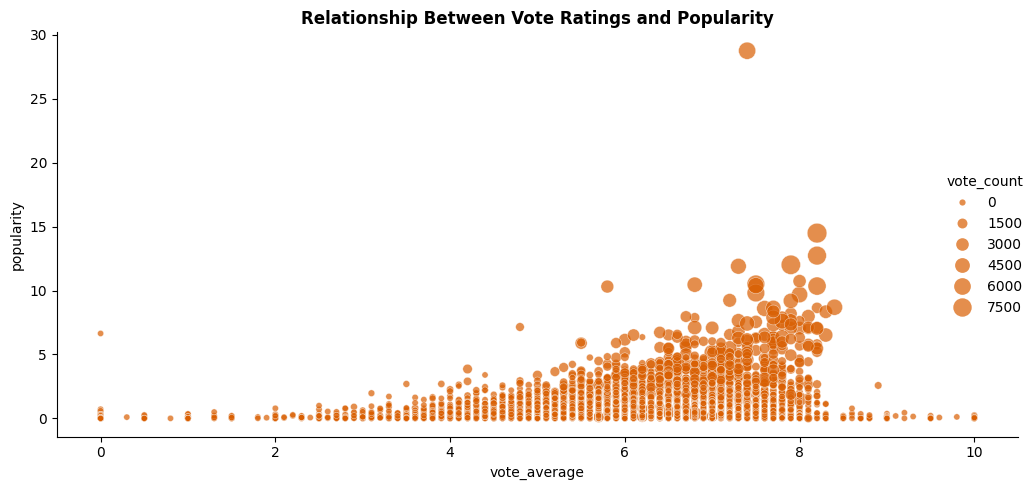

In [ ]:
# Relationship between ratings, popularity, and vote count
# Movies with extreme ratings (0 or 10) typically have few votes. Higher vote counts correlate with 6-8 ratings and higher popularity.
sns.relplot(
    data=netflix_movies_df, 
    x='vote_average', 
    y='popularity', 
    size='vote_count',
    sizes=(20, 200), 
    alpha=.7, 
    aspect=1.9, 
    height=5, 
    color='#d95f02'
)
plt.title('Relationship Between Vote Ratings and Popularity', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

<Figure size 1000x1200 with 0 Axes>

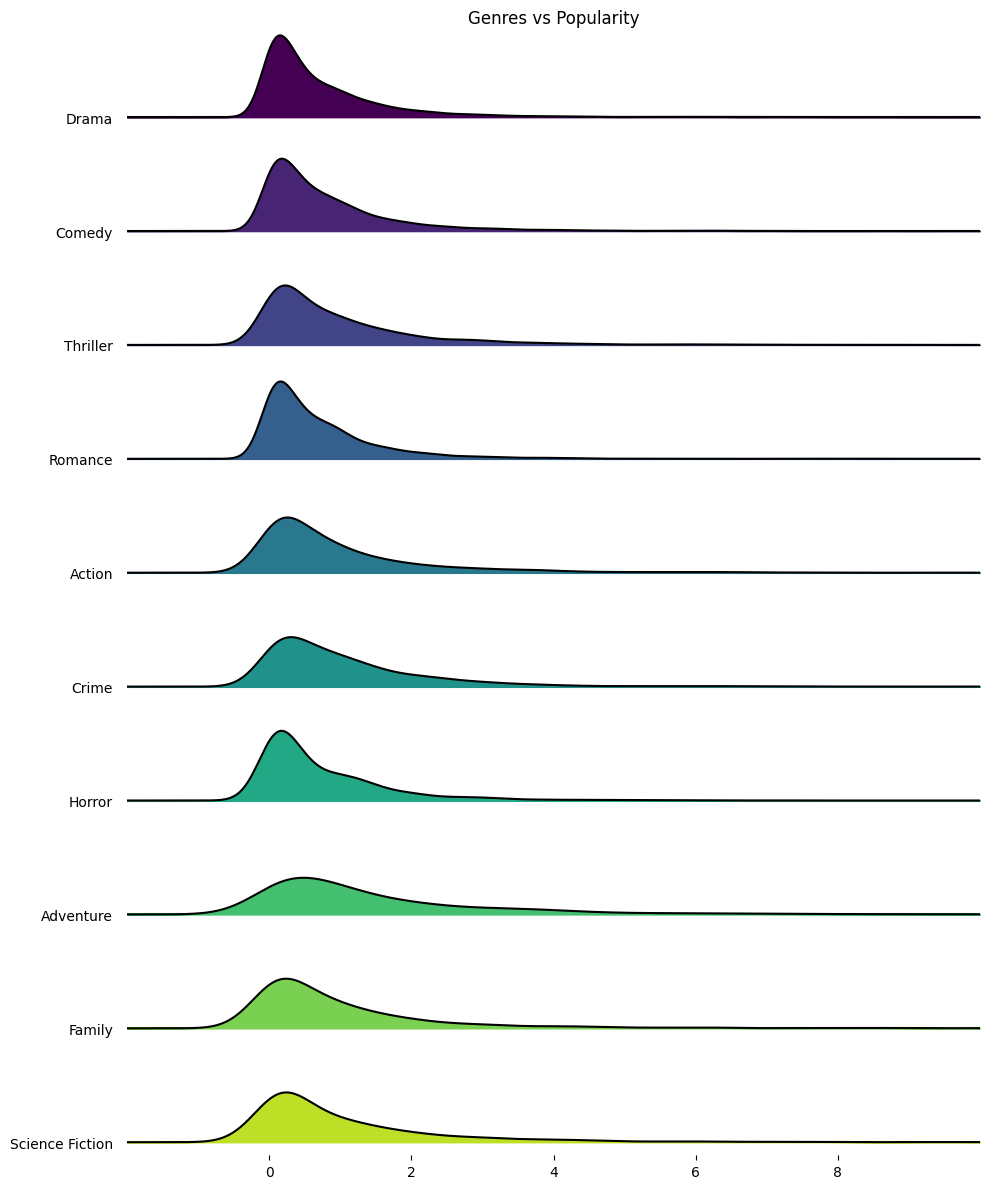

In [ ]:
# Analyzing Popularity Distribution Across Genres
top_genre_values = top_genres.index
genre_plot_df = netflix_movies_df.copy()
genre_plot_df['genres'] = genre_plot_df['genres'].str.split('|')
genre_plot_df = genre_plot_df.explode('genres')
genre_plot_df = genre_plot_df[genre_plot_df['genres'].isin(top_genre_values)]

# Create a ridge plot for genres vs popularity
plt.figure(figsize=(10, 12))
joy_data = pd.DataFrame({genre: genre_plot_df[genre_plot_df['genres'] == genre]['popularity'] 
                        for genre in top_genre_values})

joyplot(
    data=joy_data,
    figsize=(10, 12), 
    title="Genres vs Popularity",
    colormap=plt.cm.viridis,
    x_range=(-2, 10)  # Zoom into the main popularity range
)

plt.tight_layout()
plt.show()

In [44]:
# Temporal Feature: Create Release Year Bins
num_bins = 8  # You can change this as needed
min_year = netflix_movies_df["release_year"].min()
max_year = netflix_movies_df["release_year"].max()
bins = np.linspace(min_year, max_year, num_bins + 1)
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)]

# Apply binning
netflix_movies_df["release_year_bins"] = pd.cut(
    netflix_movies_df["release_year"], 
    bins=bins, 
    labels=labels, 
    right=False
)

# Drop original release_year column
netflix_movies_df.drop(columns=["release_year"], inplace=True)

## Part 3: User Ratings Analysis

In [ ]:
# List of all ratings data files
data_files = [
    '../data/raw/combined_data_1.txt',
    '../data/raw/combined_data_2.txt',
    '../data/raw/combined_data_3.txt',
    '../data/raw/combined_data_4.txt'
]
valid_movie_ids = set(pd.to_numeric(netflix_movies_df["movie_id"], errors='coerce').dropna().astype(int).to_list())
print(f"Number of valid movie IDs: {len(valid_movie_ids)}")

def process_netflix_file(file_path):
    """Process a single Netflix data file and return as a Polars DataFrame"""
    movie_id = None
    records = []
    
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.endswith(':'):
                movie_id = int(line[:-1])
                continue
                
            if movie_id is not None and line and movie_id in valid_movie_ids:
                parts = line.split(',')
                if len(parts) == 3:
                    customer_id, rating, date = int(parts[0]), int(parts[1]), parts[2]
                    records.append({
                        "movie_id": movie_id,
                        "customer_id": customer_id,
                        "rating": rating,
                        "date": date
                    })
    
    return pl.DataFrame(records)

print("Starting data processing...")
dfs = []
for file in data_files:
    print(f"Processing {file}...")
    df = process_netflix_file(file)
    dfs.append(df)
    print(f"Processed {file}, got {len(df)} records")
# Combine all DataFrames
user_ratings_df = pl.concat(dfs)
print(f"Total records: {len(user_ratings_df)}")

Number of valid movie IDs: 10850
Starting data processing...
Processing ./data/raw/combined_data_1.txt...
Processed ./data/raw/combined_data_1.txt, got 20056800 records
Processing ./data/raw/combined_data_2.txt...
Processed ./data/raw/combined_data_2.txt, got 22079515 records
Processing ./data/raw/combined_data_3.txt...
Processed ./data/raw/combined_data_3.txt, got 18014405 records
Processing ./data/raw/combined_data_4.txt...
Processed ./data/raw/combined_data_4.txt, got 20788950 records
Total records: 80939670


In [38]:
# Convert date strings to datetime objects and add month/year/weekday/is_weekday columns for later use
user_ratings_df = user_ratings_df.with_columns([
    pl.col("date").str.to_datetime("%Y-%m-%d").alias("date"),
    pl.col("date").str.to_datetime("%Y-%m-%d").dt.month().alias("month"),
    pl.col("date").str.to_datetime("%Y-%m-%d").dt.year().alias("year"),
    pl.col("date").str.to_datetime("%Y-%m-%d").dt.weekday().alias("weekday"),  # 0 = Monday, 6 = Sunday
    (pl.col("date").str.to_datetime("%Y-%m-%d").dt.weekday() < 5).alias("is_weekday")  # True if Mon-Fri
])
# Drop 'date' column
user_ratings_df = user_ratings_df.drop("date")

# Quick overview of the data
print("First 5 records:")
print(user_ratings_df.head(5))
print("\nSummary statistics:")
print(user_ratings_df.describe())

First 5 records:
shape: (5, 7)
┌──────────┬─────────────┬────────┬───────┬──────┬─────────┬────────────┐
│ movie_id ┆ customer_id ┆ rating ┆ month ┆ year ┆ weekday ┆ is_weekday │
│ ---      ┆ ---         ┆ ---    ┆ ---   ┆ ---  ┆ ---     ┆ ---        │
│ i64      ┆ i64         ┆ i64    ┆ i8    ┆ i32  ┆ i8      ┆ bool       │
╞══════════╪═════════════╪════════╪═══════╪══════╪═════════╪════════════╡
│ 1        ┆ 1488844     ┆ 3      ┆ 9     ┆ 2005 ┆ 2       ┆ true       │
│ 1        ┆ 822109      ┆ 5      ┆ 5     ┆ 2005 ┆ 5       ┆ false      │
│ 1        ┆ 885013      ┆ 4      ┆ 10    ┆ 2005 ┆ 3       ┆ true       │
│ 1        ┆ 30878       ┆ 4      ┆ 12    ┆ 2005 ┆ 1       ┆ true       │
│ 1        ┆ 823519      ┆ 3      ┆ 5     ┆ 2004 ┆ 1       ┆ true       │
└──────────┴─────────────┴────────┴───────┴──────┴─────────┴────────────┘

Summary statistics:
shape: (9, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ movi

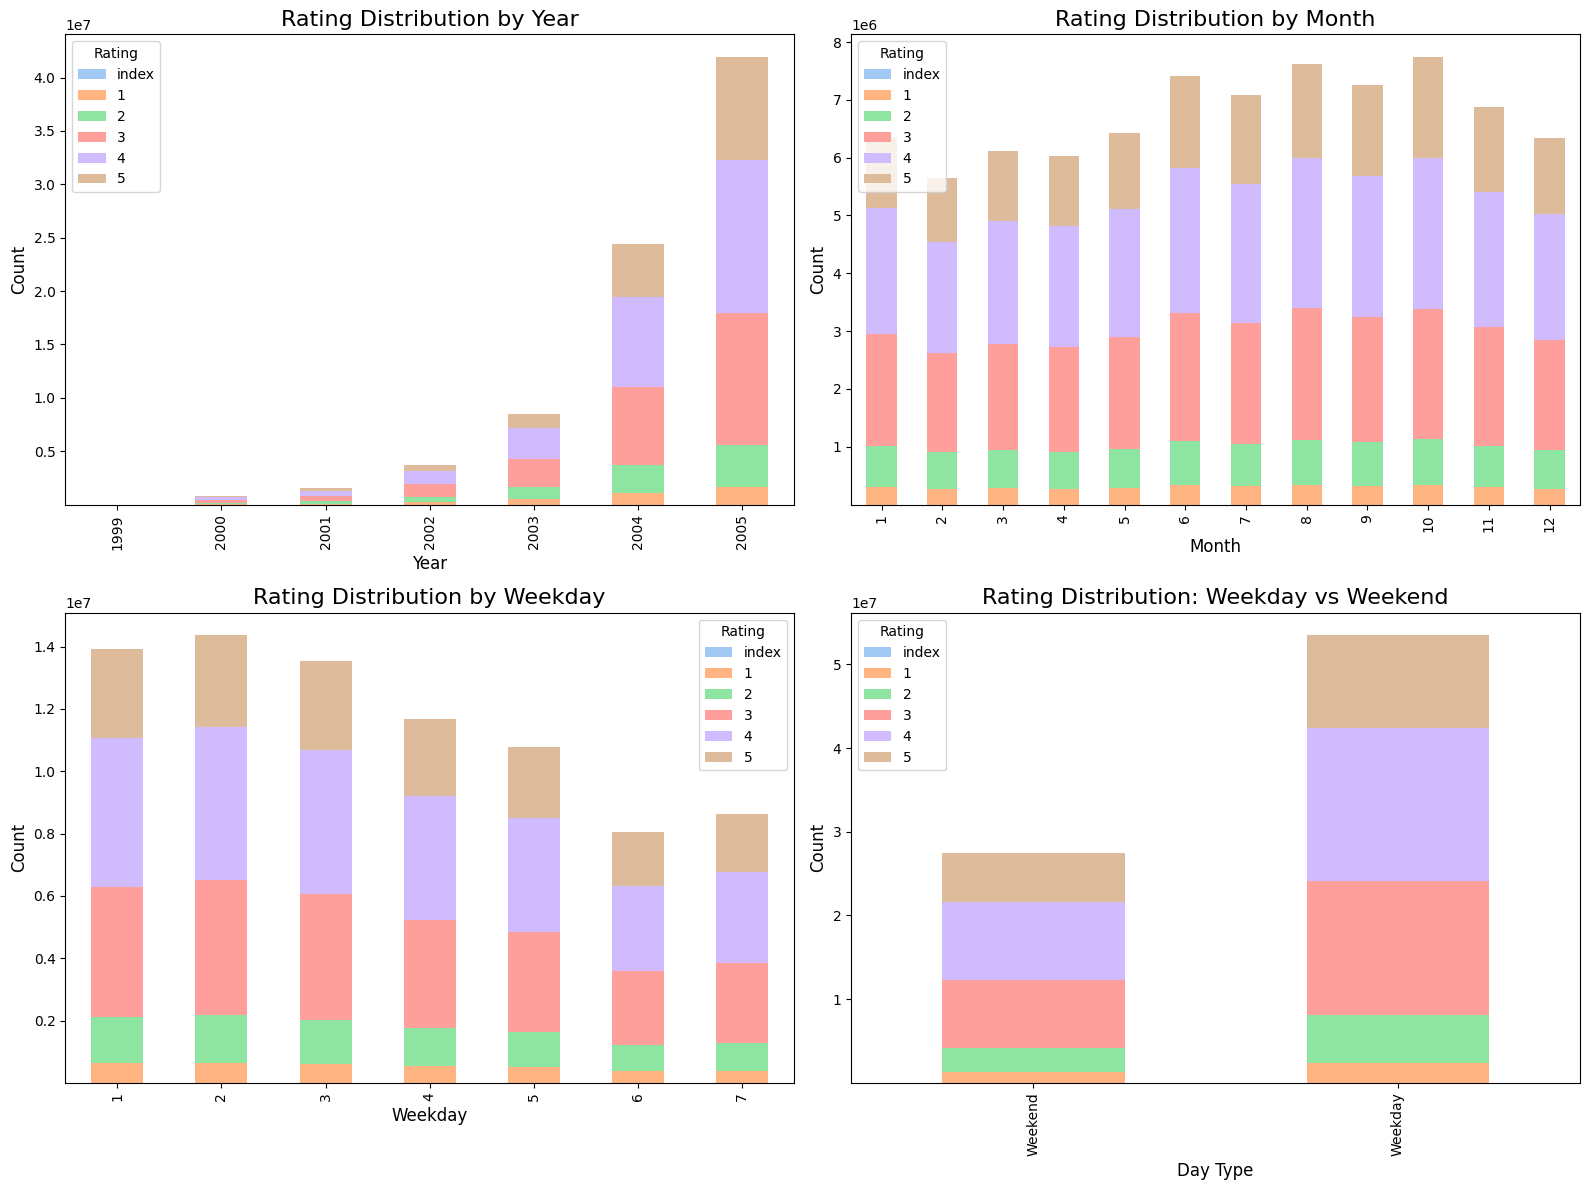

In [ ]:
# Set up visualization style
sns.set_palette("pastel")

yearly_ratings = user_ratings_df.group_by(["year", "rating"]).agg(pl.len().alias("count")).sort(["year", "rating"])
monthly_ratings = user_ratings_df.group_by(["month", "rating"]).agg(pl.len().alias("count")).sort(["month", "rating"])
weekday_ratings = user_ratings_df.group_by(["weekday", "rating"]).agg(pl.len().alias("count")).sort(["weekday", "rating"])
weekend_ratings = user_ratings_df.group_by(["is_weekday", "rating"]).agg(pl.len().alias("count")).sort(["is_weekday", "rating"])
# Convert to pandas for easier plotting
yearly_pivot = yearly_ratings.pivot(values="count", index="year", on="rating").to_pandas().reset_index()
monthly_pivot = monthly_ratings.pivot(values="count", index="month", on="rating").to_pandas().reset_index()
weekday_pivot = weekday_ratings.pivot(values="count", index="weekday", on="rating").to_pandas().reset_index()
weekend_pivot = weekend_ratings.pivot(values="count", index="is_weekday", on="rating").to_pandas().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Plot 1: Rating Distribution by Year
yearly_pivot.set_index('year').plot(kind='bar', stacked=True, ax=axes[0, 0])
axes[0, 0].set_title('Rating Distribution by Year', fontsize=16)
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].legend(title='Rating')
# Plot 2: Rating Distribution by Month
monthly_pivot.set_index('month').plot(kind='bar', stacked=True, ax=axes[0, 1])
axes[0, 1].set_title('Rating Distribution by Month', fontsize=16)
axes[0, 1].set_xlabel('Month', fontsize=12)
axes[0, 1].set_ylabel('Count', fontsize=12)
axes[0, 1].legend(title='Rating')
# Plot 3: Rating Distribution by Weekday
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_pivot.set_index('weekday').plot(kind='bar', stacked=True, ax=axes[1, 0])
axes[1, 0].set_title('Rating Distribution by Weekday', fontsize=16)
axes[1, 0].set_xlabel('Weekday', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].legend(title='Rating')
# Plot 4: Rating Distribution by Is Weekend
weekend_pivot_display = weekend_pivot.copy()
weekend_pivot_display['day_type'] = weekend_pivot_display['is_weekday'].map({True: 'Weekday', False: 'Weekend'})
weekend_pivot_display.set_index('day_type').drop('is_weekday', axis=1).plot(kind='bar', stacked=True, ax=axes[1, 1])
axes[1, 1].set_title('Rating Distribution: Weekday vs Weekend', fontsize=16)
axes[1, 1].set_xlabel('Day Type', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].legend(title='Rating')

plt.tight_layout()
plt.show()

Based on the time analysis visualizations above, I can see that movie ratings have increased significantly over time, with 2005 showing the highest volume and more 4-5 star ratings compared to earlier years. Ratings are relatively consistent across months but slightly higher during summer and fall periods. There's a clear pattern in weekday distribution where users rate more content on weekdays 1-3 (Monday-Wednesday) than later in the week. The weekday vs. weekend comparison reveals that weekdays have nearly twice the rating activity of weekends, though the proportion of high ratings (4-5) appears similar across both periods, suggesting timing affects volume but not sentiment.

Min ratings per user: 1, Max ratings per user: 10812


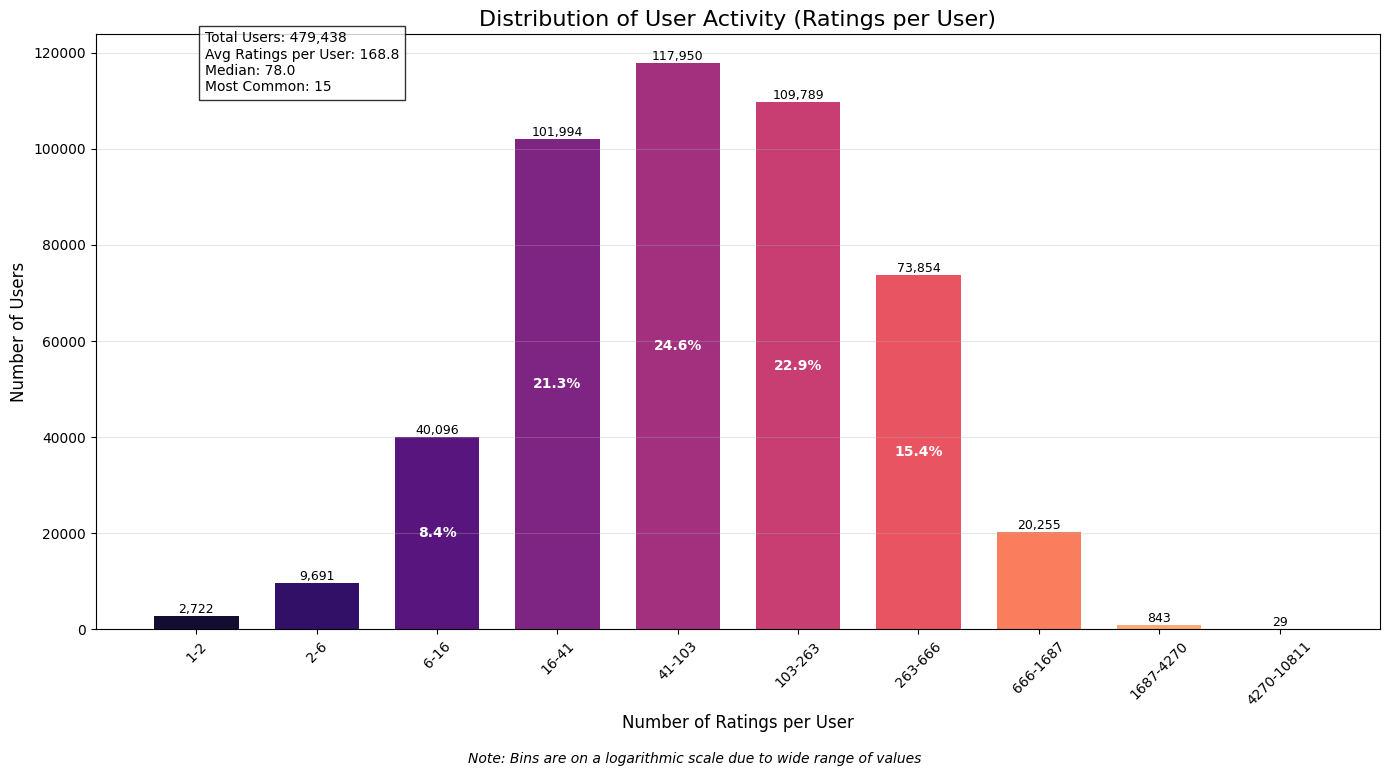

In [ ]:
# User Activity Analysis
# Calculate rating counts per user
user_activity = user_ratings_df.group_by("customer_id").agg(pl.len().alias("ratings_count"))

# Get min and max for creating bins
min_count = user_activity["ratings_count"].min()
max_count = user_activity["ratings_count"].max()
print(f"Min ratings per user: {min_count}, Max ratings per user: {max_count}")

# Determine whether to use logarithmic or linear binning
is_log_scale = max_count / min_count > 100
if is_log_scale:
    bins = np.logspace(np.log10(max(1, min_count)), np.log10(max_count), 11)
else:
    bins = np.linspace(min_count, max_count, 11)
bin_labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(10)]
user_activity_pd = user_activity.to_pandas()
user_activity_pd['count_bin'] = pd.cut(user_activity_pd['ratings_count'], bins=bins, labels=bin_labels)
binned_counts = user_activity_pd['count_bin'].value_counts().sort_index()

# Create visualization
plt.figure(figsize=(14, 8))
colors = sns.color_palette("magma", len(binned_counts))
bars = plt.bar(range(len(binned_counts)), binned_counts.values, width=0.7, color=colors)
total_users = len(user_activity)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height):,}', ha='center', va='bottom', rotation=0, fontsize=9)
    percentage = 100 * height / total_users
    if height > total_users * 0.05:  
        plt.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{percentage:.1f}%', ha='center', va='center', 
                color='white', fontweight='bold')
plt.title('Distribution of User Activity (Ratings per User)', fontsize=16)
plt.xlabel('Number of Ratings per User', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.xticks(range(len(binned_counts)), bin_labels, rotation=45)
plt.grid(axis='y', alpha=0.3)

if is_log_scale:
    plt.figtext(0.5, 0.01, "Note: Bins are on a logarithmic scale due to wide range of values", 
                ha="center", fontsize=10, style='italic')

# Add summary statistics
plt.figtext(0.15, 0.85, 
           f"Total Users: {total_users:,}\n"
           f"Avg Ratings per User: {user_activity['ratings_count'].mean():.1f}\n"
           f"Median: {user_activity['ratings_count'].median()}\n"
           f"Most Common: {user_activity['ratings_count'].mode()[0]}",
           bbox=dict(facecolor='white', alpha=0.8), fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

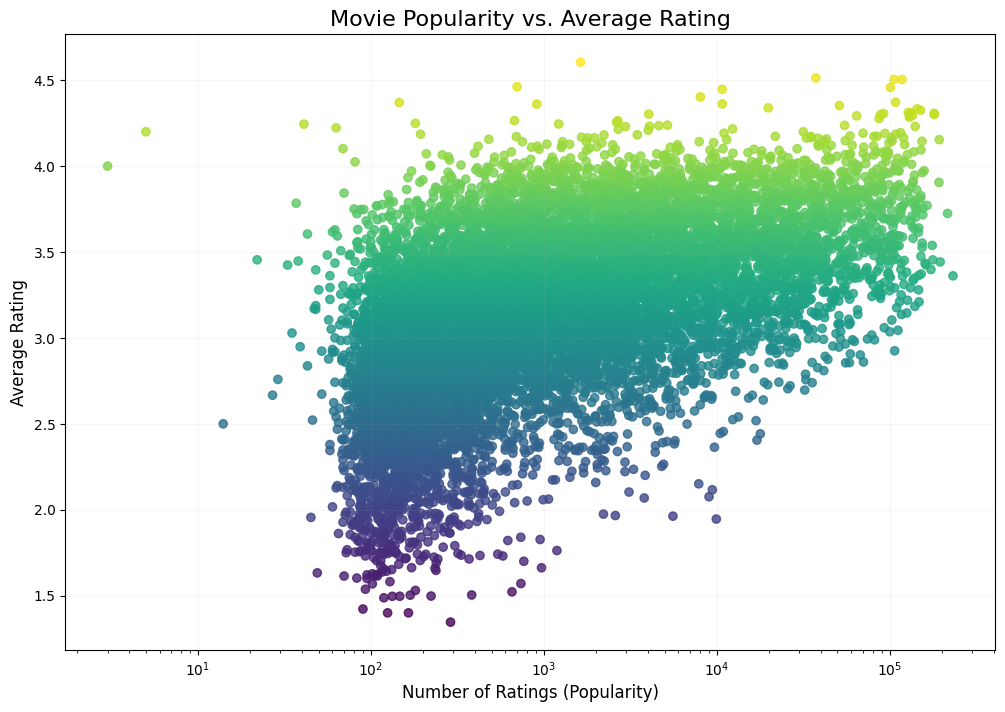

In [ ]:
# Movie Popularity vs. Average Rating Analysis
# Aggregate by movie to get popularity and average ratings
movie_stats = user_ratings_df.group_by("movie_id").agg([
    pl.len().alias("popularity"),
    pl.mean("rating").alias("avg_rating")
])

plt.figure(figsize=(12, 8))
plt.scatter(movie_stats["popularity"].to_list(), movie_stats["avg_rating"].to_list(), 
            alpha=0.8, c=movie_stats["avg_rating"].to_list(), cmap="viridis")
plt.title('Movie Popularity vs. Average Rating', fontsize=16)
plt.xlabel('Number of Ratings (Popularity)', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xscale('log') 
plt.grid(True, alpha=0.1)
plt.show()

Starting comprehensive genre analysis...


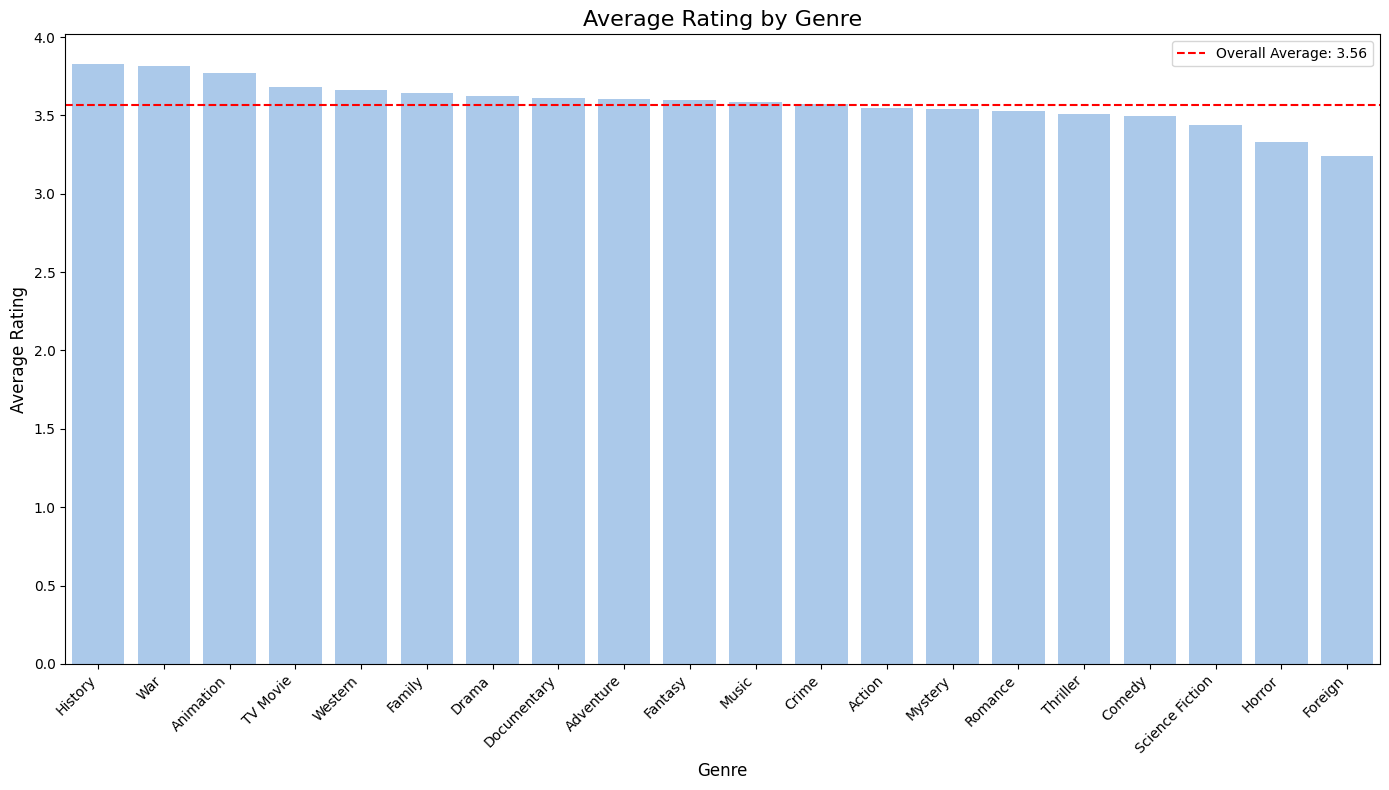

In [45]:
# Comprehensive Genre Analysis
def analyze_genres_comprehensive(user_ratings_df, netflix_movies_df, chunk_size=50000):
    """
    Analyze genres and their trends over time efficiently in chunks.
    Returns genre statistics DataFrame
    """
    print("Starting comprehensive genre analysis...")
    genre_stats = {}
    for i in range(0, len(user_ratings_df), chunk_size):
        ratings_chunk = user_ratings_df.slice(i, min(chunk_size, len(user_ratings_df) - i))
        netflix_movies_df["movie_id"] = pd.to_numeric(netflix_movies_df["movie_id"], errors="coerce")
        netflix_movies_pl = pl.from_pandas(netflix_movies_df)
        chunk_combined = ratings_chunk.join(
            netflix_movies_pl.select(["movie_id", "genres"]),
            on="movie_id",
            how="inner"
        )
        for row in chunk_combined.iter_rows(named=True):
            rating = row["rating"]
            genres = row["genres"].split("|")
            for genre in genres:
                if genre not in genre_stats:
                    genre_stats[genre] = {"count": 0, "sum": 0, "sum_sq": 0}
                genre_stats[genre]["count"] += 1
                genre_stats[genre]["sum"] += rating
                genre_stats[genre]["sum_sq"] += rating * rating
    
    # Convert overall genre stats to DataFrame
    overall_result_data = []
    for genre, stats in genre_stats.items():
        count = stats["count"]
        avg = stats["sum"] / count if count > 0 else 0
        # Calculate standard deviation
        variance = (stats["sum_sq"] / count) - (avg * avg) if count > 0 else 0
        std = max(0, variance) ** 0.5
        overall_result_data.append({"genre": genre, "count": count, "avg_rating": avg, "std_rating": std})
    
    genre_stats_df = pl.DataFrame(overall_result_data).sort("count", descending=True)
    return genre_stats_df

# Run the comprehensive genre analysis once
genre_stats = analyze_genres_comprehensive(user_ratings_df, netflix_movies_df, chunk_size=50000)

# Average Rating by Genre Visualization
# Filter for genres with sufficient data (more than 1000 ratings)
plt.figure(figsize=(14, 8))
genre_plot = genre_stats.filter(pl.col("count") > 1000)  
# Create a bar chart showing average rating by genre
sns.barplot(x="genre", y="avg_rating", data=genre_plot.to_pandas(), 
            order=genre_plot.sort("avg_rating", descending=True)["genre"].to_list())
plt.title('Average Rating by Genre', fontsize=16)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xticks(rotation=45, ha="right")
# Add reference line for overall average
overall_avg = user_ratings_df["rating"].mean()
plt.axhline(y=overall_avg, color='r', linestyle='--', 
            label=f'Overall Average: {overall_avg:.2f}')

plt.legend()
plt.tight_layout()
plt.show()

## Part 4: Create the Final Combined Dataset

In [ ]:
# Ensure netflix_movies_df is in Polars format for joining
netflix_movies_df["movie_id"] = pd.to_numeric(netflix_movies_df["movie_id"], errors="coerce")
netflix_movies_pl = pl.from_pandas(netflix_movies_df)
    
# Join the ratings data with the movie metadata
combined_df = user_ratings_df.join(
    netflix_movies_pl, 
    on="movie_id",
    how="inner"
)
print(f"Combined data has {len(combined_df)} rows")
null_genres = combined_df.filter(pl.col("genres").is_null())
print(f"Number of rows with null genres: {len(null_genres)}")

Combined data has 80939670 rows
Number of rows with null genres: 0


In [42]:
print(combined_df.head())

shape: (5, 14)
┌──────────┬─────────────┬────────┬───────┬───┬─────────────┬────────────┬────────────┬────────────┐
│ movie_id ┆ customer_id ┆ rating ┆ month ┆ … ┆ overview    ┆ popularity ┆ vote_avera ┆ vote_count │
│ ---      ┆ ---         ┆ ---    ┆ ---   ┆   ┆ ---         ┆ ---        ┆ ge         ┆ ---        │
│ i64      ┆ i64         ┆ i64    ┆ i8    ┆   ┆ str         ┆ f64        ┆ ---        ┆ i64        │
│          ┆             ┆        ┆       ┆   ┆             ┆            ┆ f64        ┆            │
╞══════════╪═════════════╪════════╪═══════╪═══╪═════════════╪════════════╪════════════╪════════════╡
│ 1        ┆ 1488844     ┆ 3      ┆ 9     ┆ … ┆ A four-epis ┆ 0.055543   ┆ 7.0        ┆ 1          │
│          ┆             ┆        ┆       ┆   ┆ ode         ┆            ┆            ┆            │
│          ┆             ┆        ┆       ┆   ┆ animated    ┆            ┆            ┆            │
│          ┆             ┆        ┆       ┆   ┆ series…     ┆            ┆  

In [ ]:
# Save the combined dataframe to parquet
combined_df.write_parquet("../data/cleaned/netflix_ratings_features_combined.parquet")
print("Data successfully saved in parquet format")
##### Reading back the parquet file
##### df_from_parquet = pl.read_parquet("netflix_ratings_movies_combined.parquet")
##### print(f"Loaded parquet data with {len(df_from_parquet)} rows")

Data successfully saved in parquet format


### Summary of Findings
 
 ### Movie Dataset Insights:
 1. **Genre Distribution**: Drama, Comedy, and Action are the most common genres in the Netflix catalog.
 2. **Rating Patterns**: Movies with extreme ratings (very high or very low) typically have fewer votes, suggesting potential bias.
 3. **Popularity vs. Ratings**: There's a positive correlation between popularity and average rating, with highly-rated movies gaining more popularity.
 4. **Production Geography**: USA dominates the production countries, accounting for more than half of all movies.
 
 ### User Behavior Insights:
 1. **Rating Distribution**: Most ratings are positive (3-5 stars), with a peak at 4 stars, suggesting a generally favorable user base.
 2. **User Activity**: User activity follows a logarithmic distribution, with a small percentage of users contributing most ratings.
 3. **Temporal Trends**: Rating activity grew exponentially from 1999-2005, showing Netflix's rapid adoption.
 4. **Genre Preferences**: Animation, History, and War genres have the highest average ratings, while Foreign films rate lowest.
 
 The cleaned, combined dataset is now ready for building recommendation systems that can leverage both movie metadata and user rating patterns.